<a href="https://colab.research.google.com/github/marcexpositg/CRISPRed/blob/master/02.Model/2.5.2.EffModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.5. Model to predict the editing efficiency

## 1. Training a classification model

A binary SVM classifier will be trained to predict the likeliness for a gRNA to belong to the active (1) or non-active (-1) classes.

gRNA activity is represented in the labels as a value between 0 and 1, which in simulated data indicates the portion of edited reads. Higher values will indicate higher activity of the gRNA. It would seem logical to train a regression model that predicts the activity in a continuous range between 0 and 1, and evaluate its performance using $R^2$ between labels and predictions. However, for simplicity, the model will be trained as a classifier predicting two classes (Active vs. Non-Active), instead of a regression model predicting a value between 0 and 1 indicating the activity of the gRNA. Nonetheless, the final output of the model will not be binary, since it is more interesting obtaining the probability of belonging to a class than just a binary prediction. By obtaining probabilities, the treshold above or below which a gRNA should be considered active/non-active can be fine-tuned to adjust for more or less false positives (find the best balance between recall and precision for our purpose).

It is logical to consider the classes as imbalanced, because random DNA sequences most likely will have low activity as gRNAs. This stresses the importance of adjusting the probability treshold to adjust recall and precision using ROC curves, and using the AUC as a goodness of fit indicator. However, training a binary classifier is much simple if both classes are equally represented in the training data. This also allows the usage of accuracy as an indicator of goodness of fit, keeping in mind that the final indicator to compare models is AUC and the profile of the ROC curve.

To create a balanced training set, data is split in quartiles, and the first quartile is assigned as the active (+1) class while the last quartile is assigned as non-active (-1). Taking as a reference a previous study (Chari et al. 2015), gRNAs will be ranked according to their activity, and the top quintile (25% of data) will be considered active, while the bottom quintile (25% of data) will be considered not active.

Using this approach, half of the gRNA library won't be used in any part of the modelling process. An alternative would be taking 20% of the top gRNAs as the active class and the remaining 80% as the non-active class, like other authors have done before (Doench et al. 2014). However, that would lead to imbalanced data and multiple corrections would have to be done. Hence, it seems more logical to train a model using only the top and bottom gRNAs. in addition, the gRNAs in the two central quartiles would not be as informative of the class as the rest.

In brief, gRNAs will be labeled as active (top quartile) and non-active (bottom quartile) and used to train a binary classifier that predicts the likeliness of a new gRNA sequence to belong to each of the two classes. Multiple binary classifier algorithms are tested, including kNN, SVM, logistic regression, and random forests. Each of the models will be optimized by testing multiple parameters, and the optimal parameters will be selected using 5-fold cross validation having accuracy as the goodness of fit indicator. Finally, the models will be compared using a ROC curve and the AUC. If needed, the probability treshold of the classes will be fine tuned using the ROC curve to minimize false negatives.

### 1.1. Labeling the data as binary classes

As mentioned above, gRNAs are ordered by activity and ranked. The top 25% gRNAs will be considered active (+1) and the bottom 25% will be considered non-active (-1).

For the sake of simplicity, both features and labels (activity) are merged in a single data frame to sort the gRNAs by activity before assigning the labels.

First, the editing efficiency of the simulated data is imported from the github repository.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
activity_labl = pd.read_csv("https://raw.githubusercontent.com/marcexpositg/CRISPRed/master/02.Model/Labels/editing_efficiency_sim.csv", names = ["ids","Efficiency"])
print(activity_labl)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            ids  Efficiency
0     ENSMUSG00000033788_gR434r        0.01
1     ENSMUSG00000033788_gR113f        0.03
2      ENSMUSG00000033788_gR70f        0.30
3     ENSMUSG00000023020_gR346r        0.26
4     ENSMUSG00000023020_gR376r        0.18
...                         ...         ...
1717  ENSMUSG00000025791_gR257r        0.49
1718  ENSMUSG00000025791_gR494f        0.67
1719  ENSMUSG00000023484_gR261f        0.13
1720  ENSMUSG00000023484_gR270f        0.04
1721  ENSMUSG00000023484_gR479f        0.45

[1722 rows x 2 columns]


The labels of the class are assigned first based on the activity.



In [2]:
activity_labl_sort = activity_labl.sort_values(by=['Efficiency'],ascending=False)
activity_labl_sort.shape[0]
activity_labl_sort["Rank"] = np.arange(1,activity_labl_sort.shape[0]+1)
activity_labl_sort["PercentRank"] = 1-activity_labl_sort["Rank"]/(activity_labl_sort.shape[0]+1)
activity_labl_sort["label"] = pd.qcut(activity_labl_sort["PercentRank"],q=[0.0,0.25,0.75,1.],labels=[-1,0,1])
activity_labl_sort["label"].value_counts() # to check number of -1 and +1

 0    860
 1    431
-1    431
Name: label, dtype: int64

Then, the features of the library are imported from Github. The labels are matched to each corresponding gRNA in the Features by its "ids".

In [3]:
features = pd.read_csv("https://raw.githubusercontent.com/marcexpositg/CRISPRed/master/02.Model/Featurization/gRNA_features.csv", header=0)
features

,ids,A0,C0,G0,T0,A1,C1,G1,T1,A2,C2,G2,T2,A3,C3,G3,T3,A4,C4,G4,T4,A5,C5,G5,T5,A6,C6,G6,T6,A7,C7,G7,T7,A8,C8,G8,T8,A9,C9,G9,...,TC16,TG16,TT16,AA17,AC17,AG17,AT17,CA17,CC17,CG17,CT17,GA17,GC17,GG17,GT17,TA17,TC17,TG17,TT17,AA18,AC18,AG18,AT18,CA18,CC18,CG18,CT18,GA18,GC18,GG18,GT18,TA18,TC18,TG18,TT18,A,C,G,T,GC_content
0,ENSMUSG00000033788_gR434r,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0,13,2,65.0
1,ENSMUSG00000033788_gR113f,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,6,5,5,55.0
2,ENSMUSG00000033788_gR70f,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5,5,8,2,65.0
3,ENSMUSG00000023020_gR346r,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,4,2,4,30.0
4,ENSMUSG00000023020_gR376r,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,5,5,6,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,ENSMUSG00000025791_gR257r,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,2,5,6,35.0
1718,ENSMUSG00000025791_gR494f,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,5,5,2,50.0
1719,ENSMUSG00000023484_gR261f,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10,5,5,0,50.0
1720,ENSMUSG00000023484_gR270f,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6,5,8,1,65.0


In [4]:
data = features.merge(activity_labl_sort[["ids","label"]],on="ids")
data

,ids,A0,C0,G0,T0,A1,C1,G1,T1,A2,C2,G2,T2,A3,C3,G3,T3,A4,C4,G4,T4,A5,C5,G5,T5,A6,C6,G6,T6,A7,C7,G7,T7,A8,C8,G8,T8,A9,C9,G9,...,TG16,TT16,AA17,AC17,AG17,AT17,CA17,CC17,CG17,CT17,GA17,GC17,GG17,GT17,TA17,TC17,TG17,TT17,AA18,AC18,AG18,AT18,CA18,CC18,CG18,CT18,GA18,GC18,GG18,GT18,TA18,TC18,TG18,TT18,A,C,G,T,GC_content,label
0,ENSMUSG00000033788_gR434r,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0,13,2,65.0,-1
1,ENSMUSG00000033788_gR113f,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,6,5,5,55.0,-1
2,ENSMUSG00000033788_gR70f,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5,5,8,2,65.0,1
3,ENSMUSG00000023020_gR346r,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,4,2,4,30.0,0
4,ENSMUSG00000023020_gR376r,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,5,5,6,50.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,ENSMUSG00000025791_gR257r,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,2,5,6,35.0,1
1718,ENSMUSG00000025791_gR494f,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,5,5,2,50.0,1
1719,ENSMUSG00000023484_gR261f,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10,5,5,0,50.0,0
1720,ENSMUSG00000023484_gR270f,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6,5,8,1,65.0,-1


gRNAs in the middle quartiles (between 0.25-0.75) have been labeled as class 0 so that they can be deleted from the data set.

In [5]:
data_bc = data[data.label != 0]
data_bc["label"].cat.remove_unused_categories(inplace=True)
data_bc["label"].value_counts()

 1    431
-1    431
Name: label, dtype: int64

### 1.2. Creating the training+validation and the test sets

Data is split in the training set (used both for training and validation using cross-validation) and the test set.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data_bc.drop(["ids","label"],axis=1),data_bc[["label"]], random_state=0, stratify=data_bc[["label"]])

In [7]:
X_train

,A0,C0,G0,T0,A1,C1,G1,T1,A2,C2,G2,T2,A3,C3,G3,T3,A4,C4,G4,T4,A5,C5,G5,T5,A6,C6,G6,T6,A7,C7,G7,T7,A8,C8,G8,T8,A9,C9,G9,T9,...,TC16,TG16,TT16,AA17,AC17,AG17,AT17,CA17,CC17,CG17,CT17,GA17,GC17,GG17,GT17,TA17,TC17,TG17,TT17,AA18,AC18,AG18,AT18,CA18,CC18,CG18,CT18,GA18,GC18,GG18,GT18,TA18,TC18,TG18,TT18,A,C,G,T,GC_content
187,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,6,8,4,70.0
349,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5,4,4,7,40.0
707,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,4,4,50.0
1591,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5,4,8,3,60.0
1678,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,6,4,5,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,4,5,6,45.0
1191,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13,1,2,4,15.0
823,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,3,5,6,40.0
227,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5,4,5,6,45.0


The `stratify` parameter indicates that the algorithm should try to maintain the proportion of gRNAs of each class (active, non-active) in both sets (test and train). The result being the same in all three comparisions indicates that both training and test set cointain the same proportion of -1 and +1 as in the original data. Since the original data has equal number of -1 and +1, its ratio is 1.0.

In [8]:
round(y_train["label"].value_counts()[0]/y_train["label"].value_counts()[1],2)

1.0

In [9]:
round(y_test["label"].value_counts()[0]/y_test["label"].value_counts()[1],2)

1.0

In [10]:
round(data_bc["label"].value_counts()[0]/data_bc["label"].value_counts()[1],2)

1.0

## 2. kNN model



### 2.1. Training

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_neighbors'   : list(range(1,31)),
    'weights'       : ["uniform","distance"], 
}

knn_cl = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, scoring="accuracy", n_jobs=-1)

In [12]:
knn_cl.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

### 2.2. Best parameters

kNN is only optimized searching for two parameters, the number of neighbors and the weights used to decide the class based on the neighbors.

In [13]:
print("Best parameters: {}".format(knn_cl.best_params_))

Best parameters: {'n_neighbors': 16, 'weights': 'distance'}


Below it is shown a diagram displaying how the accuracy values change depending on the parameter values of the third round of optimization. Since the local maximum is on the center of the map, no further tuning is required. This graph is not very intuitive, a lineal representation is much better.

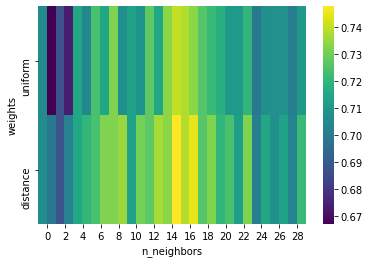

In [14]:
results_acc = pd.DataFrame(knn_cl.cv_results_)
# reshape(y_dim,x_dim)
scores_acc = np.transpose(np.array(results_acc.mean_test_score).reshape(30, 2))
hm = sns.heatmap(scores_acc, cmap="viridis", annot=False)
#hm.set(xlabel='n_neighbors', xticklabels=list(range(1,31,2)),ylabel='weights', yticklabels=parameters['weights'])
hm.set(xlabel='n_neighbors', xticks=np.arange(min(parameters['n_neighbors']),max(parameters['n_neighbors'])+1,step=2),ylabel='weights', yticklabels=parameters['weights'])
hm.set_xlim(0, 30)
plt.show()

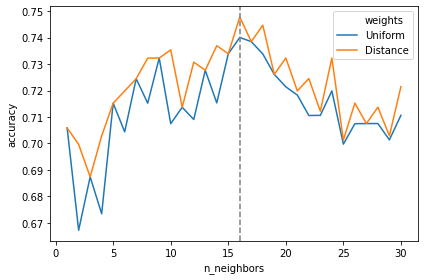

In [15]:
knn_parmsp = pd.DataFrame({"n_neighbors": parameters['n_neighbors'],"Uniform": scores_acc[0,],"Distance": scores_acc[1,]})
knn_p = pd.melt(knn_parmsp, id_vars=['n_neighbors'], value_vars=['Uniform','Distance'], var_name="weights", value_name="accuracy")
knn_lnplt = sns.lineplot(x="n_neighbors", y="accuracy", hue="weights",data=knn_p)
plt.axvline(16, 0,1, linestyle="dashed", color="grey")
plt.tight_layout()
plt.savefig("kNNmodel.png", dpi=600)
plt.show()

### 2.3. Performance


In [16]:
# Actual class predictions
knn_predictions = knn_cl.predict(X_test)
# Probabilities for each class
knn_probs = knn_cl.predict_proba(X_test)[:, 1]

In [17]:
print("Accuracy on training set: {:.3f}".format(knn_cl.score(X_train, y_train)))
print("Best cross-validation score: {:.2f}".format(knn_cl.best_score_))
print("Accuracy on test set: {:.3f}".format(knn_cl.score(X_test, y_test)))
print("Best parameters: {}".format(knn_cl.best_params_))

Accuracy on training set: 1.000
Best cross-validation score: 0.75
Accuracy on test set: 0.750
Best parameters: {'n_neighbors': 16, 'weights': 'distance'}


In [18]:
# Calculate roc auc
from sklearn.metrics import roc_auc_score
auc_value = roc_auc_score(y_test, knn_probs)
print("AUC value on test set: {:.3f}".format(auc_value))

AUC value on test set: 0.817


39


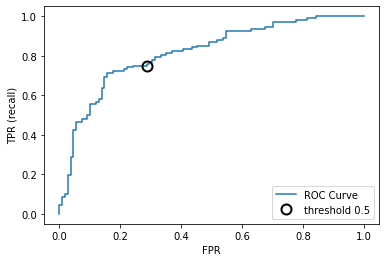

In [19]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds_knn = roc_curve(y_test, knn_cl.best_estimator_.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold (step in data) closest to 0.5 (decision at 0.5 because it is predict_proba)
# thresholds_rf contains the value depending on the threshold. we can find it by finding the one with less distance to the desired which is 0.5 which is argmin(threshold-0.5) (the one with less diference to 0.5) 
close_zero = np.argmin(np.abs(thresholds_knn - 0.5))
print(close_zero)
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
 label="threshold 0.5", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)
plt.show()

## 3. Logistic regression

### 3.1. Training

In [20]:
from sklearn.linear_model import LogisticRegression

parameters = {
    'C'             : [0.001,0.01,0.1,1,10,100],
    'penalty'       : ["l1","l2"], 
    'solver'        : ['liblinear']
}

lr_cl = GridSearchCV(LogisticRegression(), parameters, cv=5, scoring="accuracy", n_jobs=-1)

In [21]:
lr_cl.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

### 3.2. Best parameters

The parameters optimized are:
- Cost of regularization (C). The higher, the more weight is given to regularization, which prevents overfitting but can also cause underfitting. Low values of C reduce regularization and make the model prone to overfitting.
- L1 or L2 penalty for regularization. If L1 penalty is chosen, the coeficient for many predictors will be zero, which acts like a feature seleciton step. In this case, since a lot of predictors are used, probably L1 penalty is adecuate.

In [22]:
print("Best parameters: {}".format(lr_cl.best_params_))

Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


Below it is shown a diagram displaying how the accuracy values change depending on the parameter values of the third round of optimization. Since the local maximum is on the center of the map, no further tuning is required.

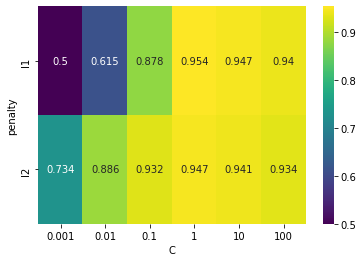

In [23]:
results_acc = pd.DataFrame(lr_cl.cv_results_)
# reshape(y_dim,x_dim)
scores_acc = np.transpose(np.array(results_acc.mean_test_score).reshape(6, 2))
hm = sns.heatmap(scores_acc, cmap="viridis", annot=True, fmt='.3g')
hm.set(xlabel='C', xticklabels=parameters['C'],ylabel='penalty', yticklabels=parameters['penalty'])
plt.show()

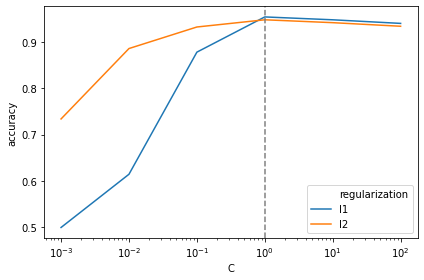

In [24]:
lr_parmsp = pd.DataFrame({"C": parameters['C'],"l1": scores_acc[0,],"l2": scores_acc[1,]})
lr_p = pd.melt(lr_parmsp, id_vars=['C'], value_vars=['l1','l2'], value_name="accuracy", var_name="regularization")
lr_lnplt = sns.lineplot(x="C", y="accuracy", hue="regularization",data=lr_p)
lr_lnplt.set_xscale('log')
plt.axvline(1, 0,1, linestyle="dashed", color="grey")
plt.tight_layout()
plt.savefig("LRmodel.png", dpi=600)
plt.show()

### 3.3. Performance


In [25]:
# Actual class predictions
lr_predictions = lr_cl.predict(X_test)
# Probabilities for each class
lr_probs = lr_cl.predict_proba(X_test)[:, 1]

In [26]:
print("Accuracy on training set: {:.3f}".format(lr_cl.score(X_train, y_train)))
print("Best cross-validation score: {:.2f}".format(lr_cl.best_score_))
print("Accuracy on test set: {:.3f}".format(lr_cl.score(X_test, y_test)))
print("Best parameters: {}".format(lr_cl.best_params_))

Accuracy on training set: 0.994
Best cross-validation score: 0.95
Accuracy on test set: 0.954
Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [27]:
# Calculate roc auc
from sklearn.metrics import roc_auc_score
auc_value = roc_auc_score(y_test, lr_probs)
print("AUC value on test set: {:.3f}".format(auc_value))

AUC value on test set: 0.982


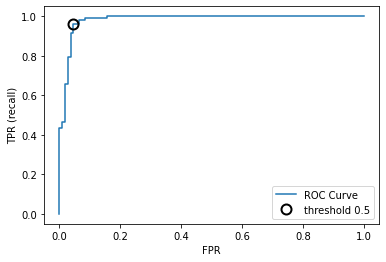

In [28]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds_lr = roc_curve(y_test, lr_cl.best_estimator_.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold (step in data) closest to 0.5 (decision at 0.5 because it is predict_proba)
# thresholds_rf contains the value depending on the threshold. we can find it by finding the one with less distance to the desired which is 0.5 which is argmin(threshold-0.5) (the one with less diference to 0.5) 
close_zero = np.argmin(np.abs(thresholds_lr - 0.5))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
 label="threshold 0.5", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)
plt.show()

## 4. SVM classifier

### 4.1. Training

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

parameters = [{'kernel': ['rbf'],
    'C'             : [0.001,0.01,0.1,1,10,100],
    'gamma'         : [0.001, 0.01, 0.1, 1, 10, 100],
    'probability'   : [True]},
    {'kernel'       : ['linear'],
    'C'             : [0.001,0.01,0.1,1,10,100],
    'gamma'         : [0.001, 0.01, 0.1, 1, 10, 100],
    'probability'   : [True]},
    {'kernel'       : ['poly'],
    'C'             : [0.001,0.01,0.1,1,10,100],
    'degree'        : [1,2,3,4,5,6],
    'probability'   : [True]}
]

svm_cl = GridSearchCV(SVC(), parameters, cv=5, scoring="accuracy", n_jobs=-1)

In [30]:
svm_cl.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                          'kernel': ['rbf'], 'probability': [True]},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                          'kernel': ['linear'], 'probability': [True]},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'degree': [1, 2, 3, 4, 5, 6], 'kern

### 4.2. Best parameters

Again, the weight of regression is adjusted (C). SVM transforms data using kernels. In this case, the poly, RBF and lineal kernels are tested.
- The poly kernel has a degree parameter indicating the degree of interactions considered. 
- The RBF kernel has a gamma parameter indicating the influence of each training point.
- The lineal kernel has no tuning possible, but a gamma parameter is added to compare it with the rest (the heatmap confirms that the result is the same regardless of the value of gamma).

In [31]:
print("Best parameters: {}".format(svm_cl.best_params_))

Best parameters: {'C': 100, 'degree': 2, 'kernel': 'poly', 'probability': True}


Below it is shown a diagram displaying how the accuracy values change depending on the parameter values of the third round of optimization. Since the local maximum is on the center of the map, no further tuning is required.

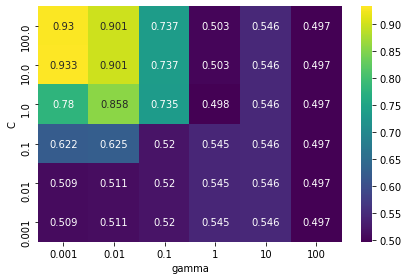

In [32]:
results_acc = pd.DataFrame(svm_cl.cv_results_)
# reshape(y_dim,x_dim)
scores_acc = np.array(results_acc.mean_test_score).reshape(3,6,6)
#rbf
hm_rbf = sns.heatmap(np.flip(scores_acc[0],0), cmap="viridis", annot=True, fmt='.3g')
hm_rbf.set(xlabel='gamma', xticklabels=parameters[0]['gamma'],ylabel='C', yticklabels=np.flip(parameters[0]['C'],0))
plt.tight_layout()
plt.savefig("SVMmodelRBF.png", dpi=600)
plt.show()

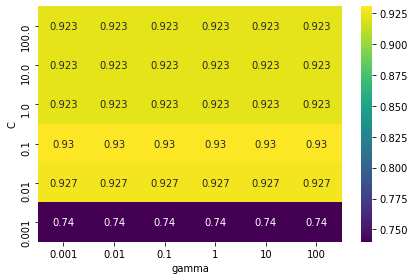

In [33]:
#lienar
hm_lin = sns.heatmap(np.flip(scores_acc[1],0), cmap="viridis", annot=True, fmt='.3g')
hm_lin.set(xlabel='gamma', xticklabels=parameters[1]['gamma'],ylabel='C', yticklabels=np.flip(parameters[1]['C'],0))
plt.tight_layout()
plt.savefig("SVMmodelLin.png", dpi=600)
plt.show()

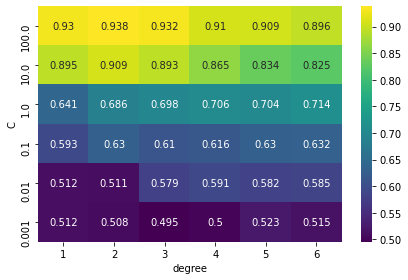

In [34]:
#polynomial
hm_pol = sns.heatmap(np.flip(scores_acc[2],0), cmap="viridis", annot=True, fmt='.3g')
hm_pol.set(xlabel='degree', xticklabels=parameters[2]['degree'],ylabel='C', yticklabels=np.flip(parameters[2]['C'],0))
plt.tight_layout()
plt.savefig("SVMmodelPoly.png", dpi=600)
plt.show()

### 4.3. Performance


In [35]:
# Actual class predictions
svm_predictions = svm_cl.predict(X_test)
# Probabilities for each class
svm_probs = svm_cl.decision_function(X_test)

In [36]:
print("Accuracy on training set: {:.3f}".format(svm_cl.score(X_train, y_train)))
print("Best cross-validation score: {:.2f}".format(svm_cl.best_score_))
print("Accuracy on test set: {:.3f}".format(svm_cl.score(X_test, y_test)))
print("Best parameters: {}".format(svm_cl.best_params_))

Accuracy on training set: 0.991
Best cross-validation score: 0.94
Accuracy on test set: 0.935
Best parameters: {'C': 100, 'degree': 2, 'kernel': 'poly', 'probability': True}


In [37]:
# Calculate roc auc
from sklearn.metrics import roc_auc_score
auc_value = roc_auc_score(y_test, svm_probs)
print("AUC value on test set: {:.3f}".format(auc_value))

AUC value on test set: 0.986


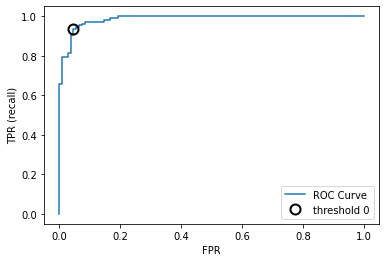

In [38]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds_svm = roc_curve(y_test, svm_cl.best_estimator_.decision_function(X_test))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold (step in data) closest to 0.5 (decision at 0.5 because it is predict_proba)
# thresholds_rf contains the value depending on the threshold. we can find it by finding the one with less distance to the desired which is 0.5 which is argmin(threshold-0.5) (the one with less diference to 0.5) 
close_zero = np.argmin(np.abs(thresholds_svm - 0))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
        label="threshold 0", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)
plt.show()

## 5. Random Forest classifier

The objective is training a Random Forest classifier exporing multiple parameters with GridSearch and 5-fold CV optimizing for accuracy. Once the best parameters are found, the performance of the model in the test set is evaluated and exported to compare with the other models.

### 5.1. Training

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Important: set random_state in Random Forests to get reproducible results!
# max_features recommended to initialize at sqrt(n_features)
# sqrt(389)=19.72
parameters = {
    'n_estimators'      : [270,280,310,330],
    'max_features'      : [6,8,15,20], 
    'max_depth'         : [15],
    'random_state'      : [0],
    #'criterion' :['gini'],
}

rf_cv = GridSearchCV(RandomForestClassifier(), parameters, cv=5, n_jobs=-1)

In [40]:
rf_cv.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

### 5.2. Best parameters

Parameters were tuned in multiple iterations testing several combinations. The parameters tuned for the Random Forest algorithm are the number of features that each tree should consider (max_features), the number of trees to be built (n_estimators), and the depth of that trees (max_depth). High values in max_depth and max_features would make the model prone to overfitting, while high values in n_estimators decrease overfitting while gaining accuracy but increase training time.

Values obtained with n_estimators 280 or 330 are the same for max_features=8, so the most simple option is selected (280) since it is easier to train.

First round:
- 'n_estimators': [280,330,370], best: 280
- 'max_features': [10,20,40], best: 10
- 'max_depth': [8, 9, 10, 11, 12], best: 12

Second round:
- 'n_estimators': [250,280,330], best: 280 
- 'max_features': [8,10,15,20], best: 8
- 'max_depth': [10, 12, 15], best 15

Third round:
- 'n_estimators': [270,280,310,330], best: 280 
- 'max_features': [6,8,15,20], best: 8
- 'max_depth': [12,15,20], best 15

Fourth round:
- 'n_estimators': [270,280,310,330], best: 280 
- 'max_features': [6,8,15,20], best: 8
- 'max_depth': [15]

In [41]:
print("Best parameters: {}".format(rf_cv.best_params_))

Best parameters: {'max_depth': 15, 'max_features': 8, 'n_estimators': 280, 'random_state': 0}


Below it is shown a diagram displaying how the accuracy values change depending on the parameter values of the third round of optimization. Since the local maximum is on the center of the map, no further tuning is suggested.

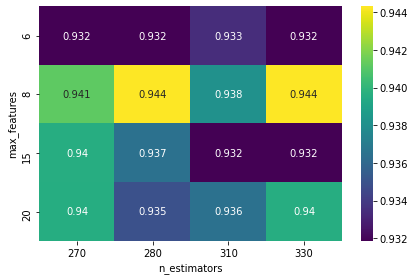

In [42]:
results_acc = pd.DataFrame(rf_cv.cv_results_)
# reshape(y_dim,x_dim)
scores_acc = np.array(results_acc.mean_test_score).reshape(4, 4)
hm = sns.heatmap(scores_acc, cmap="viridis", annot=True, fmt='.3g')
hm.set(xlabel='n_estimators', xticklabels=parameters['n_estimators'],ylabel='max_features', yticklabels=parameters['max_features'])
plt.tight_layout()
plt.savefig("RFmodel.png", dpi=600)
plt.show()

### 5.3. Performance


In [43]:
# Actual class predictions
rf_predictions = rf_cv.predict(X_test)
# Probabilities for each class
rf_probs = rf_cv.predict_proba(X_test)[:, 1]

In [44]:
print("Accuracy on training set: {:.3f}".format(rf_cv.score(X_train, y_train)))
print("Best cross-validation score: {:.2f}".format(rf_cv.best_score_))
print("Accuracy on test set: {:.3f}".format(rf_cv.score(X_test, y_test)))
print("Best parameters: {}".format(rf_cv.best_params_))

Accuracy on training set: 1.000
Best cross-validation score: 0.94
Accuracy on test set: 0.935
Best parameters: {'max_depth': 15, 'max_features': 8, 'n_estimators': 280, 'random_state': 0}


In [45]:
# Calculate roc auc
from sklearn.metrics import roc_auc_score
auc_value = roc_auc_score(y_test, rf_probs)
print("AUC value on test set: {:.3f}".format(auc_value))

AUC value on test set: 0.977


14


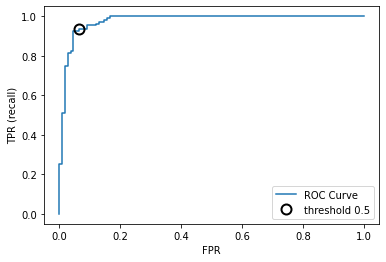

In [46]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds_rf = roc_curve(y_test, rf_cv.best_estimator_.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold (step in data) closest to 0.5 (decision at 0.5 because it is predict_proba)
# thresholds_rf contains the value depending on the threshold. we can find it by finding the one with less distance to the desired which is 0.5 which is argmin(threshold-0.5) (the one with less diference to 0.5) 
close_zero = np.argmin(np.abs(thresholds_rf - 0.5))
print(close_zero)
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
 label="threshold 0.5", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)
plt.show()

### 5.4. Visualizations

Random Forest is an easy to understand model.

For instance, one of the 220 trees can be visualized to have an idea of how the features are used.

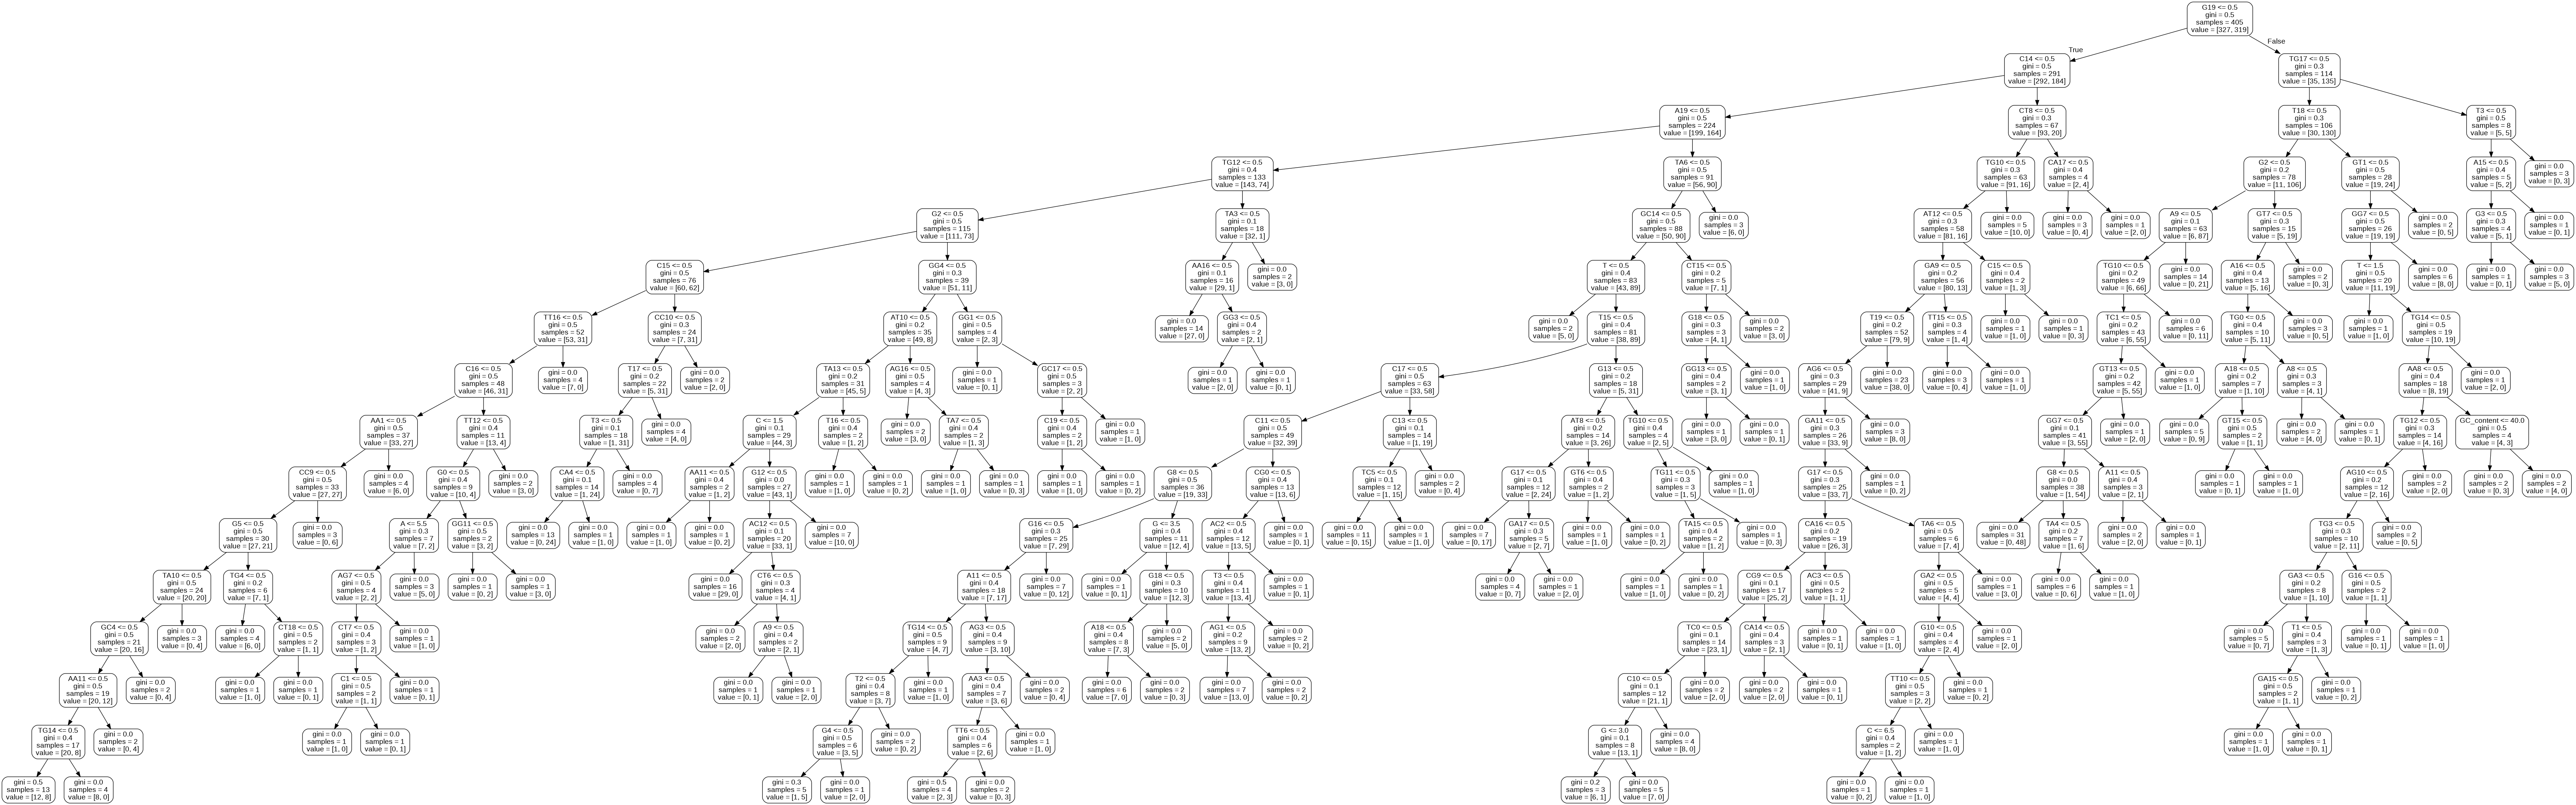

In [47]:
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf_cv.best_estimator_.estimators_[5]
tree
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = features.columns[1:], rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')
from IPython.display import Image
Image('tree.png') # width=100, height=100

Also, the importance of each feature can be assessed. The first visualization is not good, so the second one shows only the importances of the 15 most important features.

In [48]:
# Get numerical feature importances
importances = list(rf_cv.best_estimator_.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(features.columns[1:], importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
# the output is not shown to reduce the size of the output. 
# Basically, all variables have some importance because some of the 220 trees use them, but some of them have higher importance than the others.
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

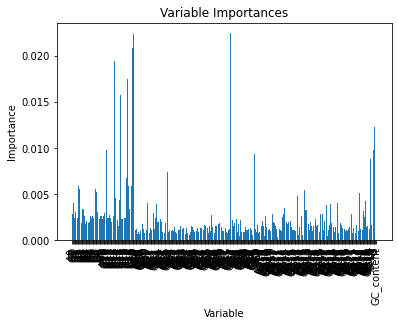

In [49]:
# This visualization is not clear at all!!

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, features.columns[1:], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

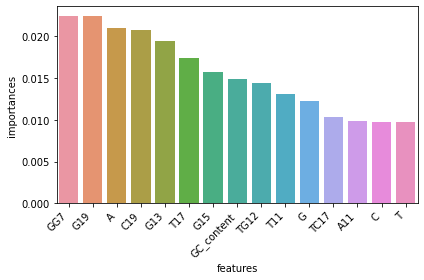

In [50]:
# This visualization is much better:
importances   = list(rf_cv.best_estimator_.feature_importances_)
feature_list  = features.drop(["ids"],axis=1).columns
feat_imp      = pd.DataFrame({"importances":importances,"features":feature_list})
feat_imp_st   = feat_imp.sort_values(by='importances', ascending=False)
feat_bp = sns.barplot(x="features", y="importances", data=feat_imp_st.iloc[:15,])
feat_bp.set_xticklabels(feat_bp.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()
plt.savefig("RF_importance.png", dpi=600)
plt.show()

## 6. Decision tree classifier

The objective is training a Decision tree classifier exporing multiple parameters with GridSearch and 5-fold CV optimizing for accuracy. Once the best parameters are found, the performance of the model in the test set is evaluated and exported to compare with the other models.

### 6.1. Training

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Important: set random_state in Random Forests to get reproducible results!
# max_features recommended to initialize at sqrt(n_features)
# sqrt(389)=19.72
parameters = {
    'max_leaf_nodes'    : list(range(2, 100)),
    'min_samples_split' : [2],
    'random_state'      : [0]
}

dt_cv = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5, n_jobs=-1)

In [52]:
dt_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,


### 6.2. Best parameters

Parameters were tuned in multiple iterations testing several combinations. The parameter tuned for the Decision Tree algorithm is the size of it, controlled by the number of nodes in `max_leaf_nodes`.


In [53]:
print("Best parameters: {}".format(dt_cv.best_params_))

Best parameters: {'max_leaf_nodes': 15, 'min_samples_split': 2, 'random_state': 0}


Below it is shown a diagram displaying how the accuracy values change depending on the parameter values.

In [54]:
results_acc = pd.DataFrame(dt_cv.cv_results_)
scores_acc = np.transpose(np.array(results_acc.mean_test_score).reshape(98, 1))

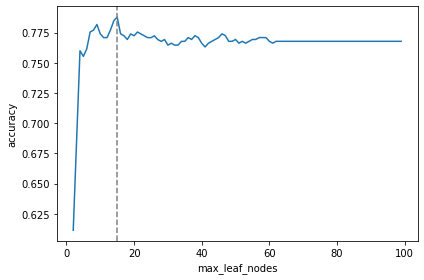

In [55]:
dt_parmsp = pd.DataFrame({"max_leaf_nodes": parameters['max_leaf_nodes'],"accuracy": scores_acc[0,]})
dt_p = pd.melt(dt_parmsp, id_vars=['max_leaf_nodes'], value_vars=['accuracy'], value_name="accuracy", var_name="regularization")
dt_lnplt = sns.lineplot(x="max_leaf_nodes", y="accuracy", data=dt_p)
plt.axvline(15, 0,1, linestyle="dashed", color="grey")
plt.tight_layout()
plt.savefig("DTmodel.png", dpi=600)
plt.show()

### 6.3. Performance


In [56]:
# Actual class predictions
dt_predictions = dt_cv.predict(X_test)
# Probabilities for each class
dt_probs = dt_cv.predict_proba(X_test)[:, 1]

In [57]:
print("Accuracy on training set: {:.3f}".format(dt_cv.score(X_train, y_train)))
print("Best cross-validation score: {:.2f}".format(dt_cv.best_score_))
print("Accuracy on test set: {:.3f}".format(dt_cv.score(X_test, y_test)))
print("Best parameters: {}".format(dt_cv.best_params_))

Accuracy on training set: 0.873
Best cross-validation score: 0.79
Accuracy on test set: 0.833
Best parameters: {'max_leaf_nodes': 15, 'min_samples_split': 2, 'random_state': 0}


In [58]:
# Calculate roc auc
from sklearn.metrics import roc_auc_score
auc_value = roc_auc_score(y_test, dt_probs)
print("AUC value on test set: {:.3f}".format(auc_value))

AUC value on test set: 0.872


6


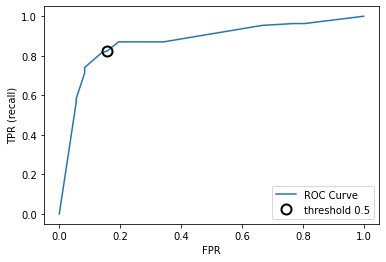

In [59]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds_dt = roc_curve(y_test, dt_cv.best_estimator_.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
close_zero = np.argmin(np.abs(thresholds_dt - 0.5))
print(close_zero)
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
 label="threshold 0.5", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)
plt.show()

### 6.4. Visualizations

Decision trees can be easy to interpret. The decision tree can be visualized to have an idea of how the features are used.

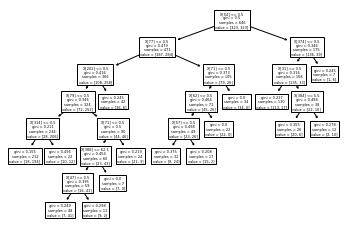

In [60]:
from sklearn.tree import plot_tree
plot_tree(dt_cv.best_estimator_)
plt.show()

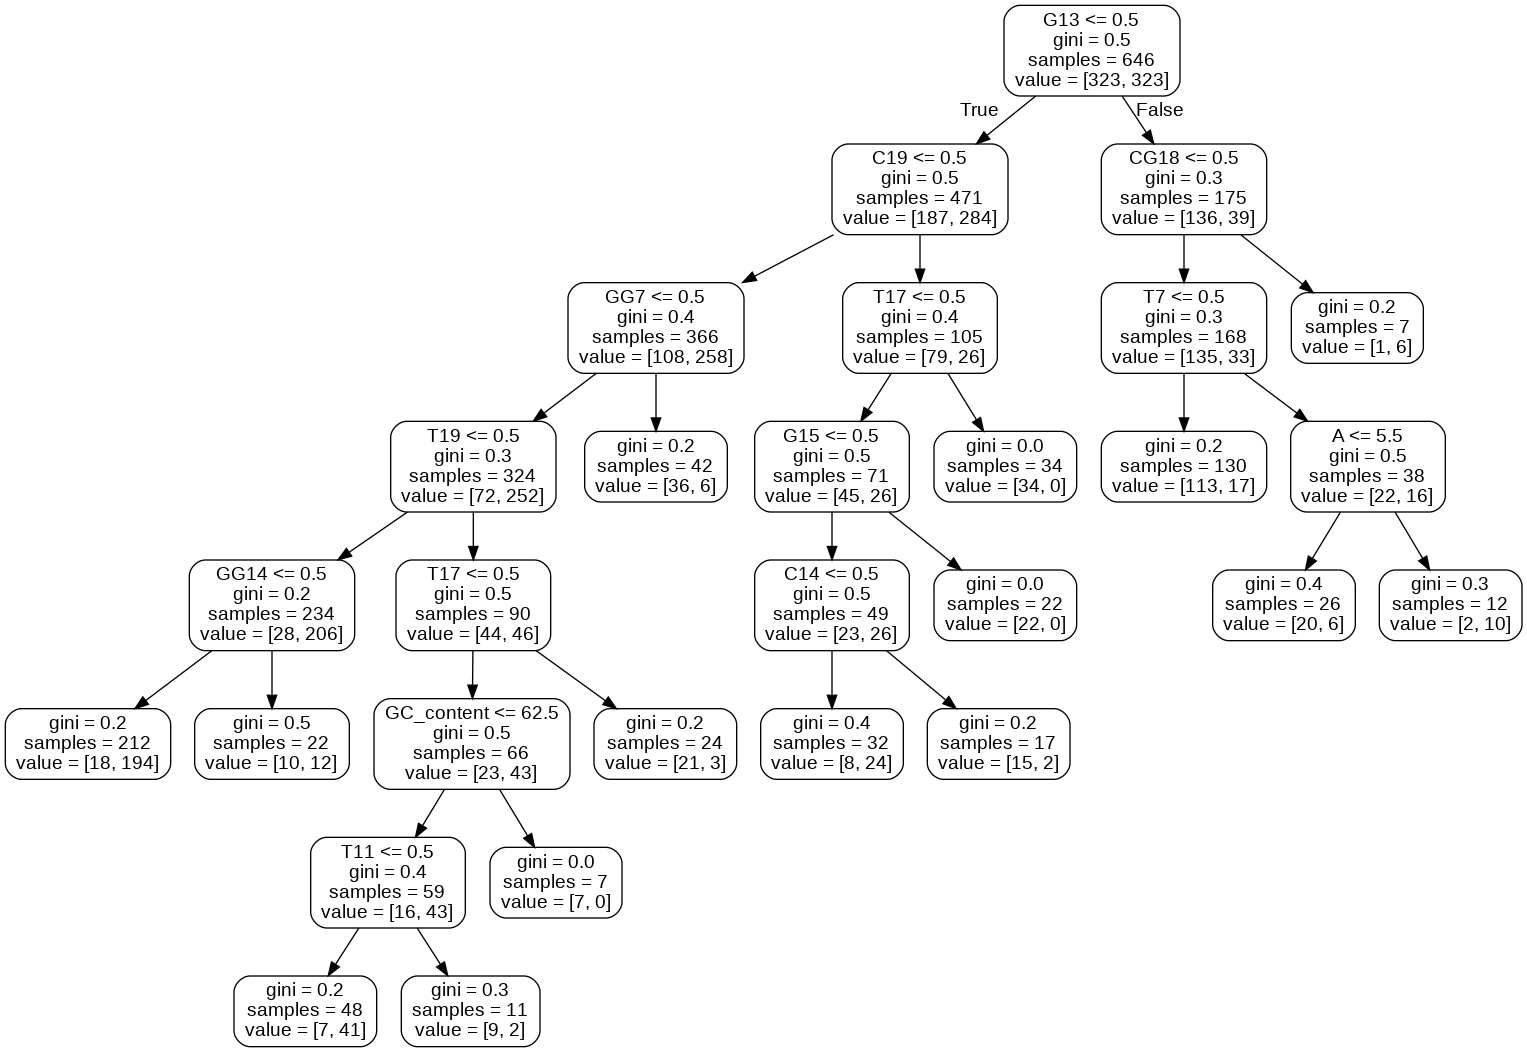

In [61]:
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = dt_cv.best_estimator_
tree
# Export the image to a dot file
export_graphviz(tree, out_file = 'Dtree.dot', feature_names = features.columns[1:], rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('Dtree.dot')
# Write graph to a png file
graph.write_png('Dtree.png')
from IPython.display import Image
Image('Dtree.png') # width=100, height=100

Also, the importance of each feature can be assessed. The first visualization is not good, so the second one shows only the importances of the 15 most important features.

In [62]:
# Get numerical feature importances
importances = list(dt_cv.best_estimator_.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(features.columns[1:], importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

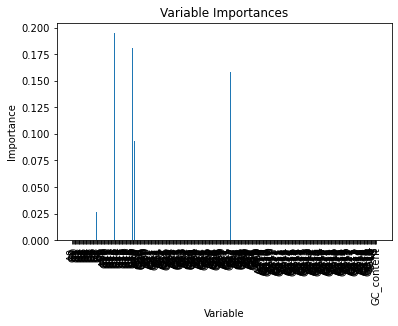

In [63]:
# This visualization is not clear at all!!

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, features.columns[1:], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

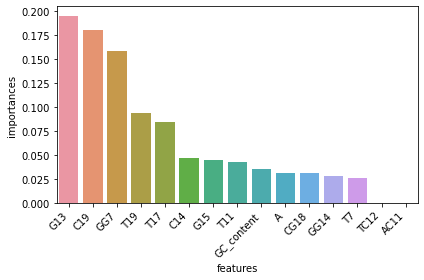

In [64]:
# This visualization is much better:
importances   = list(dt_cv.best_estimator_.feature_importances_)
feature_list  = features.drop(["ids"],axis=1).columns
feat_imp      = pd.DataFrame({"importances":importances,"features":feature_list})
feat_imp_st   = feat_imp.sort_values(by='importances', ascending=False)
feat_bp = sns.barplot(x="features", y="importances", data=feat_imp_st.iloc[:15,])
feat_bp.set_xticklabels(feat_bp.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()
plt.savefig("DT_importance.png", dpi=600)
plt.show()

## 7. Compare models

Logistic Regression is the best one to maximize sensibility. Random Forest and SVM perform equally well. kNN is clearly not the best model.

In [65]:
from sklearn.metrics import roc_auc_score
knn_probs = knn_cl.best_estimator_.predict_proba(X_test)[:, 1]
knn_auc   = roc_auc_score(y_test, knn_probs)
lr_probs  = lr_cl.best_estimator_.predict_proba(X_test)[:, 1]
lr_auc    = roc_auc_score(y_test, lr_probs)
svm_probs = svm_cl.best_estimator_.predict_proba(X_test)[:, 1]
svm_auc   = roc_auc_score(y_test, svm_probs)
rf_probs  = rf_cv.best_estimator_.predict_proba(X_test)[:, 1]
rf_auc    = roc_auc_score(y_test, rf_probs)
dt_probs  = dt_cv.best_estimator_.predict_proba(X_test)[:, 1]
dt_auc    = roc_auc_score(y_test, dt_probs)

In [66]:
knn_auc_labl = 'kNN, AUC: ' + '{:.3f}'.format(knn_auc)
lr_auc_labl  = 'LR, AUC: ' + '{:.3f}'.format(lr_auc)
svm_auc_labl = 'SVM, AUC: ' + '{:.3f}'.format(svm_auc)
rf_auc_labl  = 'RF, AUC: ' + '{:.3f}'.format(rf_auc)
dt_auc_labl  = 'DT, AUC: ' + '{:.3f}'.format(dt_auc)

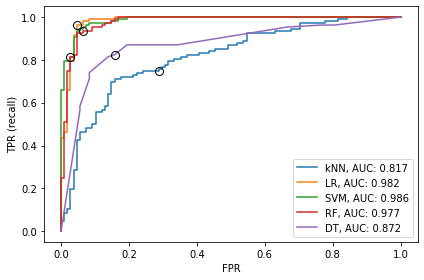

In [67]:
from sklearn.metrics import roc_curve
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn_cl.best_estimator_.predict_proba(X_test)[:, 1])
plt.plot(knn_fpr, knn_tpr, label=knn_auc_labl)
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, lr_cl.best_estimator_.predict_proba(X_test)[:, 1])
plt.plot(lr_fpr, lr_tpr, label=lr_auc_labl)
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, svm_cl.best_estimator_.decision_function(X_test))
plt.plot(svm_fpr, svm_tpr, label=svm_auc_labl)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_cv.best_estimator_.predict_proba(X_test)[:, 1])
plt.plot(rf_fpr, rf_tpr, label=rf_auc_labl)
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dt_cv.best_estimator_.predict_proba(X_test)[:, 1])
plt.plot(dt_fpr, dt_tpr, label=dt_auc_labl)

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
knn_close_zero = np.argmin(np.abs(knn_thresholds - 0.5))
plt.plot(knn_fpr[knn_close_zero], knn_tpr[knn_close_zero], 'o', markersize=8, fillstyle="none", c='k', mew=1)
lr_close_zero = np.argmin(np.abs(lr_thresholds - 0.5))
plt.plot(lr_fpr[lr_close_zero], lr_tpr[lr_close_zero], 'o', markersize=8, fillstyle="none", c='k', mew=1)
svm_close_zero = np.argmin(np.abs(svm_thresholds - 0.5))
plt.plot(svm_fpr[svm_close_zero], svm_tpr[svm_close_zero], 'o', markersize=8, fillstyle="none", c='k', mew=1)
rf_close_zero = np.argmin(np.abs(rf_thresholds - 0.5))
plt.plot(rf_fpr[rf_close_zero], rf_tpr[rf_close_zero], 'o', markersize=8, fillstyle="none", c='k', mew=1)
dt_close_zero = np.argmin(np.abs(dt_thresholds - 0.5))
plt.plot(dt_fpr[dt_close_zero], dt_tpr[dt_close_zero], 'o', markersize=8, fillstyle="none", c='k', mew=1)
plt.legend(loc=4)
plt.tight_layout()
plt.savefig("ROC curve.png", dpi=600)
plt.show()

## 8. Compare predictions with the real values

The objective of this model is comparing the predictions made by the model with the original efficiency values. Note that original efficiencies were also obtained from a computational model. However, there are differences in the prediction. Note as well that, only for comparision purposes, the data used to train the model is used to make predictions.

In [68]:
activity_labl.sort_values(by="Efficiency", ascending=False)

,ids,Efficiency
941,ENSMUSG00000028479_gR113f,0.92
1468,ENSMUSG00000063450_gR147f,0.91
450,ENSMUSG00000078566_gR14r,0.90
664,ENSMUSG00000022270_gR214r,0.89
155,ENSMUSG00000052852_gR315r,0.87
...,...,...
848,ENSMUSG00000043153_gR244f,0.00
872,ENSMUSG00000034064_gR72r,0.00
893,ENSMUSG00000025007_gR285r,0.00
895,ENSMUSG00000025007_gR66r,0.00


The following graph shows a dispersion plot placing each gRNA region of interest depending on the predicted and real efficiency values. The real valures are the values obtained from the simulated data, that were used to train and test the model like if they were experimental data. Each observation is colored blue if belongs to the -1 class (bottom quartile of activity in real data), orange if belongs to the middle quartiles (not used for training) and green if it belongs to the +1 class (top quartile of activity in "real" data).

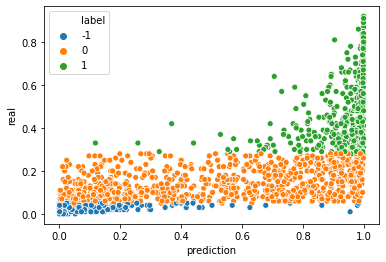

In [69]:
feats_toPred = features.drop(['ids'], axis=1)
all_pred = lr_cl.best_estimator_.predict_proba(feats_toPred)[:, 1]
comp_lit = pd.DataFrame({'ids':activity_labl.loc[:,"ids"], 'real':activity_labl.loc[:,"Efficiency"],'prediction':all_pred})
sns.scatterplot(x='prediction', y='real', hue=data.label , data=comp_lit)
plt.show()

The first plot shows the distribution of efficiencies in the real data that comes from the simulation. The second plot shows the distribution of efficiencies predicted by the model from the same regions. The model trends to push the values to 0 or 1 in comparision with the original data.

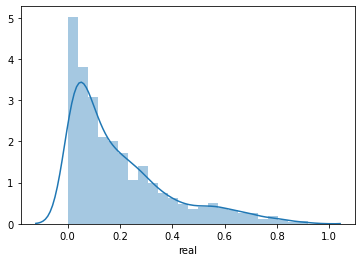

In [70]:
sns.distplot(comp_lit.real)
plt.show()

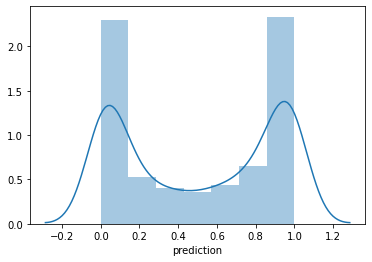

In [71]:
sns.distplot(comp_lit.prediction)
plt.show()

The dispersion plot is not very clear. It helps if data is studied in groups, in this case, by quintiles. This recreates a figure from Doench et al 2014, where they use it to assess the validity of their model. This is the code used to make that figure:

In [72]:
quint_levels = ["lowest","0.2-0.4","0.4-0.6","0.6-0.8","highest"]

In [73]:
comp_lit['real_quint'] = pd.qcut(comp_lit.sort_values(by='real',ascending=True).real,
                                 q=[0.0,0.2,0.4,0.6,0.8,1.],
                                 labels=quint_levels)
comp_lit['pred_quint'] = pd.qcut(comp_lit.sort_values(by='prediction',ascending=True).prediction,
                                 q=[0.0,0.2,0.4,0.6,0.8,1.],
                                 labels=quint_levels)
comp_lit

,ids,real,prediction,real_quint,pred_quint
0,ENSMUSG00000033788_gR434r,0.01,0.000811,lowest,lowest
1,ENSMUSG00000033788_gR113f,0.03,0.148302,lowest,0.2-0.4
2,ENSMUSG00000033788_gR70f,0.30,0.995986,0.6-0.8,highest
3,ENSMUSG00000023020_gR346r,0.26,0.836443,0.6-0.8,0.6-0.8
4,ENSMUSG00000023020_gR376r,0.18,0.755718,0.4-0.6,0.4-0.6
...,...,...,...,...,...
1717,ENSMUSG00000025791_gR257r,0.49,0.981527,highest,highest
1718,ENSMUSG00000025791_gR494f,0.67,0.998839,highest,highest
1719,ENSMUSG00000023484_gR261f,0.13,0.644189,0.4-0.6,0.4-0.6
1720,ENSMUSG00000023484_gR270f,0.04,0.001035,lowest,lowest


In [74]:
comp_lit['real_quint'].value_counts()

lowest     396
0.4-0.6    365
highest    337
0.6-0.8    327
0.2-0.4    297
Name: real_quint, dtype: int64

In [75]:
comp_lit['pred_quint'].value_counts()

highest    345
lowest     345
0.6-0.8    344
0.4-0.6    344
0.2-0.4    344
Name: pred_quint, dtype: int64

In [76]:
# Rows are "predicted" activites and columns are "real" activities 
cnt_rlts = pd.DataFrame(columns=quint_levels)
for quintile in quint_levels:
  cnts = comp_lit.loc[comp_lit['real_quint'] == quintile,"pred_quint"].value_counts()
  cnt_rlts[quintile] = cnts

In [77]:
cnt_rlts

,lowest,0.2-0.4,0.4-0.6,0.6-0.8,highest
lowest,273,54,14,4,0
0.2-0.4,106,118,92,28,0
0.4-0.6,14,83,149,86,12
0.6-0.8,2,35,80,123,104
highest,1,7,30,86,221


In [78]:
# normalize each row
from sklearn.preprocessing import Normalizer
cnt_rlts.iloc[:,:] = Normalizer(norm='l1').fit_transform(cnt_rlts)

In [79]:
# accumulative and inverse to stack in desired order
cnt_rlts_acc = 1-cnt_rlts.cumsum(axis=1)

Conclusion from the graph: More than 60% of the gRNAs predicted in the top quintile were in the most active quintile in real data. Up to 90% of the top predicted had more real activity than 60% of the gRNAs. About 80% of the gRNAs predicted as the least active were in the least active quartile of real activities, and nearly all the gRNAs predcited as least active were below the median real activity.

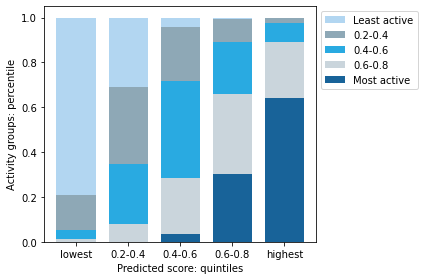

In [80]:
# plot
barWidth = 0.75
edgeCol = 'none'

plt.bar(quint_levels, cnt_rlts[quint_levels[0]], bottom=cnt_rlts_acc[quint_levels[0]], color='#b2d6f1', edgecolor=edgeCol, width=barWidth, label="Least active")
plt.bar(quint_levels, cnt_rlts[quint_levels[1]], bottom=cnt_rlts_acc[quint_levels[1]], color='#8ea8b6', edgecolor=edgeCol, width=barWidth, label="0.2-0.4")
plt.bar(quint_levels, cnt_rlts[quint_levels[2]], bottom=cnt_rlts_acc[quint_levels[2]], color='#29aae1', edgecolor=edgeCol, width=barWidth, label="0.4-0.6")
plt.bar(quint_levels, cnt_rlts[quint_levels[3]], bottom=cnt_rlts_acc[quint_levels[3]], color='#cad5dc', edgecolor=edgeCol, width=barWidth, label="0.6-0.8")
plt.bar(quint_levels, cnt_rlts[quint_levels[4]], color='#186399', edgecolor=edgeCol, width=barWidth, label="Most active")

plt.xticks(quint_levels, quint_levels)
plt.xlabel('Predicted score: quintiles')
plt.ylabel('Activity groups: percentile')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.tight_layout()
plt.savefig("ModelvsReal.png", dpi=600)
plt.show()


Isotonic regression compares the order of the data, in other words: are the gRNAs considered more efficient in the prediction also more efficient in reality? It is like linear regression but just cares about the order of the data, not the linearity of it.

The R^2 score of the model is:  0.671


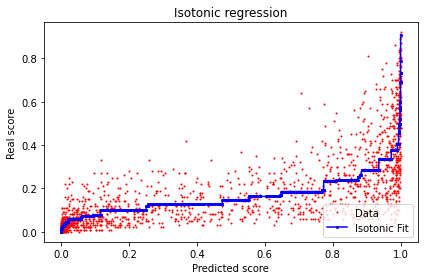

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression

comp_sort = comp_lit.sort_values(by="prediction", ascending=True)

y  = comp_sort['real']
x  = comp_sort['prediction']
n  = len(comp_sort)
ir = IsotonicRegression()

y_ = ir.fit_transform(x, y)

r_sqrt = ir.score(x,y)
print("The R^2 score of the model is: ",round(r_sqrt,3))

fig = plt.figure()
plt.plot(x, y, 'r.', markersize=2)
plt.plot(x, y_, 'b.-', markersize=4)
plt.legend(('Data', 'Isotonic Fit'), loc='lower right')
plt.title('Isotonic regression')
plt.xlabel('Predicted score')
plt.ylabel('Real score')
plt.tight_layout()
plt.savefig("IsotonicRegress.png", dpi=600)
plt.show()

The R^2 score of the model is:  0.678


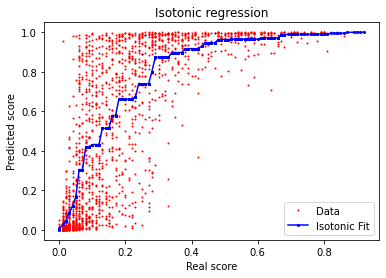

In [82]:
# This is the other possible visualization of the same graph. I find the previous one more helpful.
comp_sort = comp_lit.sort_values(by="real", ascending=True)

x  = comp_sort['real']
y  = comp_sort['prediction']
n  = len(comp_sort)
ir = IsotonicRegression()

y_ = ir.fit_transform(x, y)

r_sqrt = ir.score(x,y)
print("The R^2 score of the model is: ",round(r_sqrt,3))

# Plot result
fig = plt.figure()
plt.plot(x, y, 'r.', markersize=2)
plt.plot(x, y_, 'b.-', markersize=4)
plt.legend(('Data', 'Isotonic Fit'), loc='lower right')
plt.title('Isotonic regression')
plt.ylabel('Predicted score')
plt.xlabel('Real score')
plt.show()